In [2]:
import os
import sys
from os.path import join
from argparse import ArgumentParser
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scGraphLLM.config import graph_kernel_attn_3L_4096
from scGraphLLM.inference import get_cell_embeddings, get_gene_embeddings
from scGraphLLM.models import GDTransformer
from scGraphLLM import RegulatoryNetwork, GeneVocab, GraphTokenizer, InferenceDataset

In [3]:
os.chdir("/hpc/mydata/rowan.cassius/vcp")

In [4]:
immune_cells = sc.read_h5ad("data/human_immune_cells.h5ad")
immune_cells

AnnData object with n_obs × n_vars = 2473 × 11971
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'sample_id', 'cluster', 'set'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'X_pca'
    layers: 'counts'

In [4]:
vocab = GeneVocab.load_default()
vocab

GeneVocab with 19,247 genes
Special tokens present: ['<CLS>', '<PAD>', '<MASK>']

In [5]:
model = GDTransformer.load_from_checkpoint("model.ckpt", config=graph_kernel_attn_3L_4096)

In [6]:
emb_list = []
for cell_type in immune_cells.obs["cell_type"].unique():
    print(f"Per{cell_type} cells...")

    # select cells in cell_type
    cells = immune_cells[immune_cells.obs["cell_type"] == cell_type]
    
    print(cells)

    # load cell type network
    network = RegulatoryNetwork.from_csv(f"networks/{cell_type}/network.tsv", sep="\t")
    print(f"{cell_type} network...")
    print(network)

    # initialize dataset
    dataset = InferenceDataset(
        expression=cells.to_df(), 
        tokenizer=GraphTokenizer(vocab=vocab, network=network)
    )

    # get cell embeddings
    x = get_cell_embeddings(dataset, model, vocab, cls_policy="include", batch_size=64)

    # join with metadata
    emb = ad.AnnData(x.values, obs=cells.obs.loc[x.index])
    emb_list.append(emb)


Percd14_monocytes cells...
View of AnnData object with n_obs × n_vars = 291 × 11971
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'sample_id', 'cluster', 'set'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'X_pca'
    layers: 'counts'
cd14_monocytes network...
RegulatoryNetwork with 2,008 edges between 1,352 genes.
Number of regulons: 436
Median targets per regulon: 2
Top regulators (by out-degree): ENSG00000170345 (107), ENSG00000158552 (66), ENSG00000183734 (34)
Cache Directory: None
Observation Count: 291


Forward Pass:   0%|          | 0/5 [00:00<?, ?it/s]

Forward Pass: 100%|██████████| 5/5 [00:22<00:00,  4.54s/it]


Percd16_monocytes cells...
View of AnnData object with n_obs × n_vars = 253 × 11971
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'sample_id', 'cluster', 'set'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'X_pca'
    layers: 'counts'
cd16_monocytes network...
RegulatoryNetwork with 1,235 edges between 776 genes.
Number of regulons: 229
Median targets per regulon: 2
Top regulators (by out-degree): ENSG00000172845 (38), ENSG00000197343 (26), ENSG00000103495 (26)
Cache Directory: None
Observation Count: 253


Forward Pass: 100%|██████████| 4/4 [00:13<00:00,  3.50s/it]


Percd20_b_cells cells...
View of AnnData object with n_obs × n_vars = 300 × 11971
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'sample_id', 'cluster', 'set'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'X_pca'
    layers: 'counts'
cd20_b_cells network...
RegulatoryNetwork with 1,127 edges between 782 genes.
Number of regulons: 283
Median targets per regulon: 2
Top regulators (by out-degree): ENSG00000181222 (33), ENSG00000133639 (30), ENSG00000125740 (29)
Cache Directory: None
Observation Count: 300


Forward Pass: 100%|██████████| 5/5 [00:11<00:00,  2.36s/it]


Percd4_t_cells cells...
View of AnnData object with n_obs × n_vars = 300 × 11971
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'sample_id', 'cluster', 'set'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'X_pca'
    layers: 'counts'
cd4_t_cells network...
RegulatoryNetwork with 1,370 edges between 899 genes.
Number of regulons: 301
Median targets per regulon: 2
Top regulators (by out-degree): ENSG00000164587 (103), ENSG00000147604 (75), ENSG00000106245 (29)
Cache Directory: None
Observation Count: 300


Forward Pass: 100%|██████████| 5/5 [00:11<00:00,  2.34s/it]


Percd8_t_cells cells...
View of AnnData object with n_obs × n_vars = 300 × 11971
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'sample_id', 'cluster', 'set'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'X_pca'
    layers: 'counts'
cd8_t_cells network...
RegulatoryNetwork with 3,153 edges between 1,722 genes.
Number of regulons: 522
Median targets per regulon: 3
Top regulators (by out-degree): ENSG00000164587 (236), ENSG00000089009 (74), ENSG00000085224 (42)
Cache Directory: None
Observation Count: 300


Forward Pass: 100%|██████████| 5/5 [00:12<00:00,  2.41s/it]


Pererythrocytes cells...
View of AnnData object with n_obs × n_vars = 300 × 11971
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'sample_id', 'cluster', 'set'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'X_pca'
    layers: 'counts'
erythrocytes network...
RegulatoryNetwork with 19,397 edges between 3,086 genes.
Number of regulons: 538
Median targets per regulon: 9
Top regulators (by out-degree): ENSG00000169714 (506), ENSG00000196531 (459), ENSG00000166848 (439)
Cache Directory: None
Observation Count: 300


Forward Pass: 100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


Permonocyte-derived_dendritic_cells cells...
View of AnnData object with n_obs × n_vars = 129 × 11971
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'sample_id', 'cluster', 'set'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'X_pca'
    layers: 'counts'
monocyte-derived_dendritic_cells network...
RegulatoryNetwork with 5,316 edges between 1,792 genes.
Number of regulons: 394
Median targets per regulon: 3
Top regulators (by out-degree): ENSG00000157514 (248), ENSG00000106245 (219), ENSG00000148737 (183)
Cache Directory: None
Observation Count: 129


Forward Pass: 100%|██████████| 3/3 [00:05<00:00,  1.87s/it]


Pernk_cells cells...
View of AnnData object with n_obs × n_vars = 300 × 11971
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'sample_id', 'cluster', 'set'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'X_pca'
    layers: 'counts'
nk_cells network...
RegulatoryNetwork with 403 edges between 411 genes.
Number of regulons: 163
Median targets per regulon: 1
Top regulators (by out-degree): ENSG00000164587 (48), ENSG00000152518 (29), ENSG00000171476 (29)
Cache Directory: None
Observation Count: 300


Forward Pass: 100%|██████████| 5/5 [00:11<00:00,  2.31s/it]


Pernkt_cells cells...
View of AnnData object with n_obs × n_vars = 300 × 11971
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'sample_id', 'cluster', 'set'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'X_pca'
    layers: 'counts'
nkt_cells network...
RegulatoryNetwork with 2,508 edges between 1,190 genes.
Number of regulons: 348
Median targets per regulon: 2
Top regulators (by out-degree): ENSG00000109111 (56), ENSG00000171161 (54), ENSG00000066427 (51)
Cache Directory: None
Observation Count: 300


Forward Pass: 100%|██████████| 5/5 [00:11<00:00,  2.31s/it]


In [7]:
from scGraphLLM.preprocess import concatenate_partitions
emb = concatenate_partitions(emb_list, require_matching_metadata=True)

In [8]:
# rescale and project onto principal components
sc.pp.scale(emb, zero_center=True)
sc.tl.pca(emb, svd_solver='arpack')

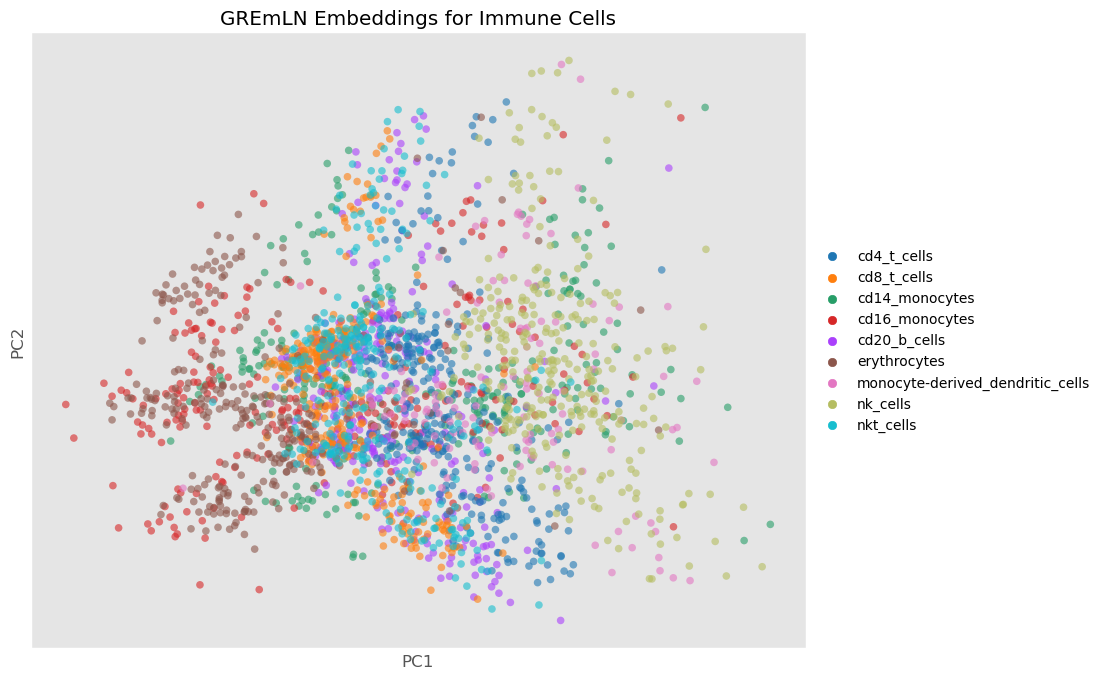

In [67]:
fig, ax = plt.subplots(figsize=(10, 8))
sc.pl.pca(emb, color="cell_type", ax=ax, size=120, alpha=0.6, title="GREmLN Embeddings for Immune Cells")

In [10]:
epithelial_cells = sc.read_h5ad("data/epithelial_cells.h5ad")
epithelial_cells

AnnData object with n_obs × n_vars = 1000 × 19221
    obs: 'index', 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'observation_joinid', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'index', 'soma_joinid', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'


In [11]:
epithelial_network = RegulatoryNetwork.from_csv("networks/epithelial_cell/network.tsv", sep="\t")
epithelial_network

RegulatoryNetwork with 183,247 edges between 14,628 genes.
Number of regulons: 1,926
Median targets per regulon: 54
Top regulators (by out-degree): ENSG00000164104 (981), ENSG00000124766 (670), ENSG00000059728 (594)

In [ ]:
# Get gene embeddings and join with gene metadata
epithelial_dataset = InferenceDataset(
    expression=epithelial_cells.to_df(),
    tokenizer=GraphTokenizer(vocab=vocab, network=epithelial_network)
)

x_gene = get_gene_embeddings(epithelial_dataset, model=model, vocab=vocab)

Cache Directory: None
Observation Count: 1,000


Forward Pass:   0%|          | 0/4 [00:00<?, ?it/s]

Forward Pass: 100%|██████████| 4/4 [01:30<00:00, 22.54s/it]


In [41]:
gene_emb = ad.AnnData(x_gene.values, obs=epithelial_cells.var.loc[x_gene.index])
gene_emb

AnnData object with n_obs × n_vars = 13706 × 512
    obs: 'index', 'soma_joinid', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [42]:
# Project on to principal components
sc.tl.pca(gene_emb, svd_solver='arpack', random_state=12345)

In [ ]:
# analyze gene regulon size
regulon_size = epithelial_network.df.groupby(network.reg_name).size()
gene_emb.obs = gene_emb.obs.join(regulon_size.rename("regulon_size"))
gene_emb.obs["regulon_label"] = pd.cut(gene_emb.obs["regulon_size"], bins=[1, 99, np.inf], labels=["<100 Targets", "100+ Targets"], include_lowest=True)
gene_emb.obs["mean_counts_quartile"] = pd.qcut(gene_emb.obs["mean_counts"], q=4, labels=["Q1", "Q2", "Q3", "Q4"])

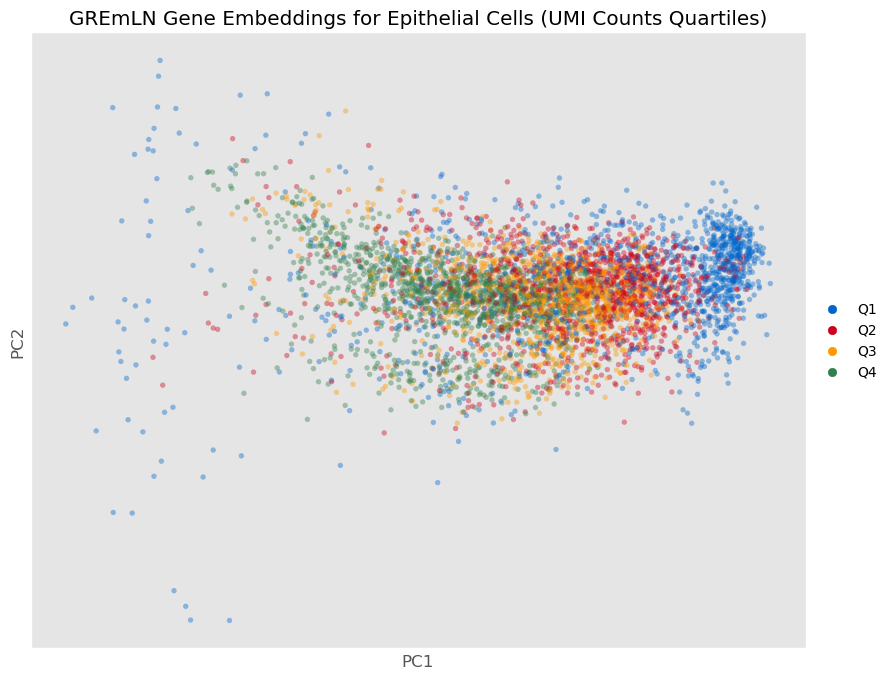

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sc.pl.pca(
    adata=sc.pp.subsample(gene_emb, n_obs=5000, copy=True), 
    color="n_cells_by_counts_quartile", 
    ax=ax, size=60, alpha=0.4, 
    palette=[(.0, .4, .8), (.8, 0, .1), (1.0, 0.6, 0.0), (.2, .5, 0.3)],
    title="GREmLN Gene Embeddings for Epithelial Cells (UMI Counts Quartiles)"
)

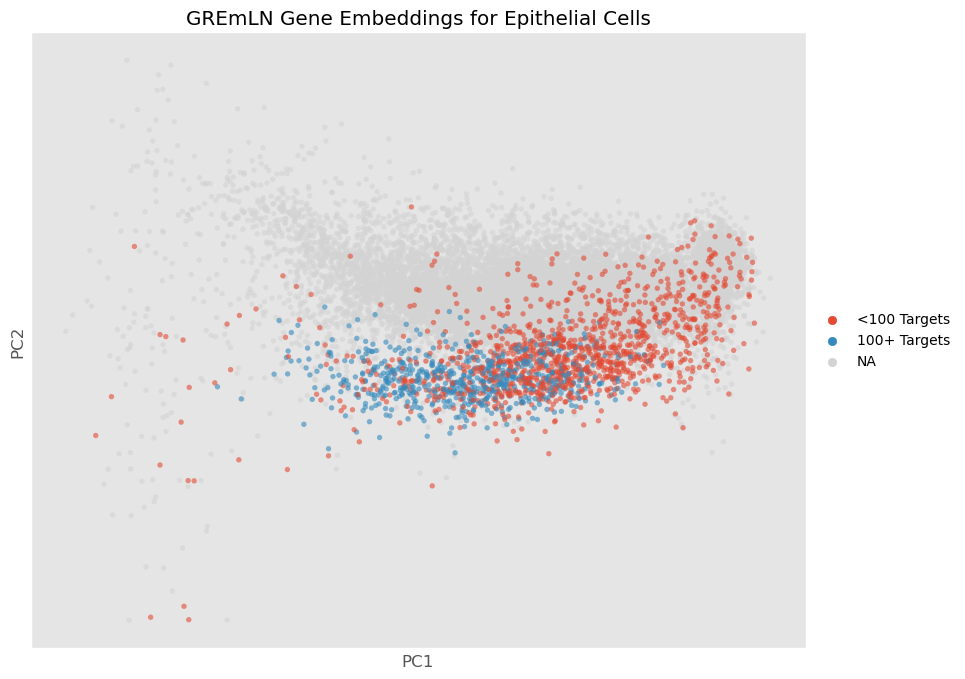

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))
sc.pl.pca(gene_emb, color="regulon_label", ax=ax, size=60, alpha=0.6, title="GREmLN Gene Embeddings for Epithelial Cells")

In [ ]:
from sklearn.metrics import pairwise_distances 

# get embeddings of regulators with large regulons (> 100 targets in regulatory network)
reg_emb = gene_emb[gene_emb.obs["regulon_size"] >= 100]

# calculate pairwise distances between genes
dist =  pairwise_distances(reg_emb.obsm["X_pca"], metric="euclidean")

gene_index = {gene: i for i, gene in enumerate(reg_emb.obs_names)}


In [ ]:
# calculate regulon similarity for a random sample of 2000 regulator pairs
from itertools import permutations

def jaccard(A, B):
    A, B = set(A), set(B)
    return len(A & B) / len(A | B)


pairs = list(permutations(reg_emb.obs_names, 2))
rng = rng = np.random.default_rng(seed=42)
sample = rng.choice(pairs, size=2000, replace=False)

jaccards = []
distance = []
for a, b in sample:
    idx_a = gene_index[a]
    idx_b = gene_index[b]
    d = dist[idx_a, idx_b]
    
    targets_a = epithelial_network.targets_of(a)
    targets_b = epithelial_network.targets_of(b)
    j = jaccard(targets_a, targets_b)

    jaccards.append(j)
    distance.append(d)


Text(0.5, 1.0, 'Regulon Similarity by Gene Distance')

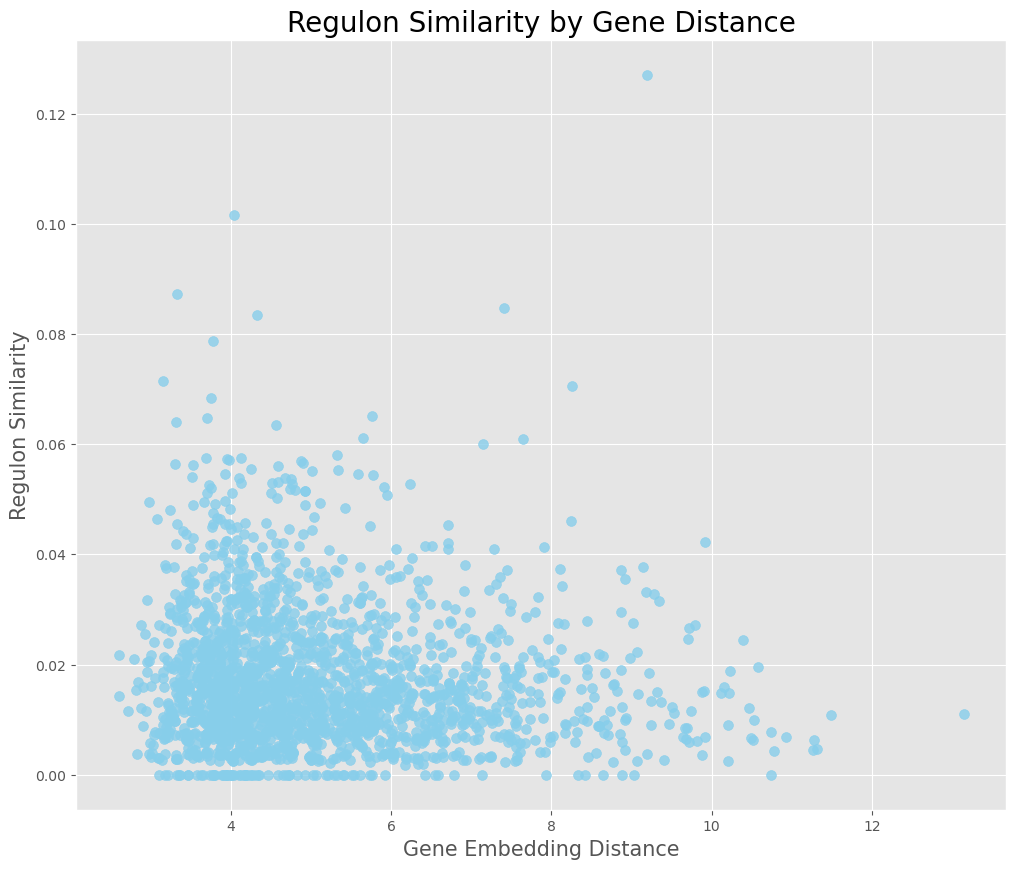

In [25]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(12, 10))  # adjust size if needed
ax.scatter(distance, jaccards, color='skyblue', alpha=0.8, s=50)
ax.set_xlabel("Gene Embedding Distance", fontsize=15)
ax.set_ylabel("Regulon Similarity", fontsize=15)
ax.set_title("Regulon Similarity by Gene Distance", fontsize=20)


In [30]:
# Test the relationship statistically 
import statsmodels.api as sm
model = sm.OLS(endog=jaccards, exog=sm.add_constant(distance))
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     15.75
Date:                Mon, 30 Jun 2025   Prob (F-statistic):           7.48e-05
Time:                        08:41:27   Log-Likelihood:                 5898.6
No. Observations:                2000   AIC:                        -1.179e+04
Df Residuals:                    1998   BIC:                        -1.178e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0211      0.001     21.741      0.0